## Task 3
For this exercise the hour.csv dataset will be used from kaggle, for bike rentals counts & time series analysis.

Times series anlaysis involves examining data points collected at regular points collected at regular times intervals to uncover patterns, trends and relationships over time.

Clean and pre-process the dataset as required and prepare the data for modelling.

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
#Load data
bike_rentals = pd.read_csv("Datasets/hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
#Concise summary of Data
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Since this about time series analysis we dont need the index of the data, but we are more intrested in the time-point the obesrvation was collected.
So we need to change the index of the dataframe to the date.

In [4]:
#Change Index
bike_rentals = bike_rentals.set_index("dteday")

#Since the date does not contain hours we add them
bike_rentals.index = pd.to_datetime(bike_rentals.index) + pd.to_timedelta(bike_rentals["hr"], unit="h")

#We need to sort the index
bike_rentals = bike_rentals.sort_index()

#Check how the dataset looks
bike_rentals.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
2011-01-01 00:00:00,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We have to check for misssing & duplicated values.

In [5]:
#Check for missing values
bike_rentals.isnull().sum()

instant       0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [6]:
#Check for duplicated Values
bike_rentals.duplicated().sum()

np.int64(0)

In [7]:
#Explore the duplicates values
bike_rentals[bike_rentals.duplicated(keep=False)]

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


We can see there are no missing values, and regarding the duplicates with firther exploration are not identical but have some same values, which is normal , since it is time seires analysis and time is itterative.

Regarding the Data Cleaning we are going to delete
columns instant, registered and casual since we dont need it for the particular time analysis.
 

In [8]:
#Drop "Instant Columns"
bike_rentals.drop(columns=["instant", "casual", "registered"], inplace=True)

Let make a plot about our data as well as a seasonal decomposition for months to get an idea how our model looks like.

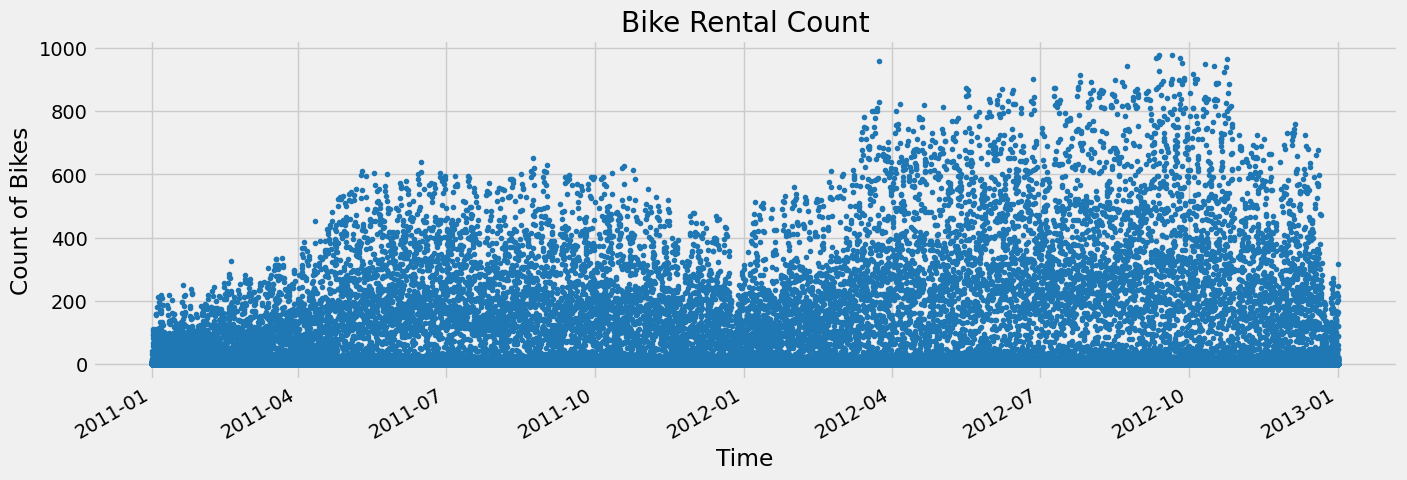

In [9]:
#Visualize Data
bike_rentals.plot(style='.', figsize=(15,5),color=color_pal[0], title="Bike Rental Count", legend=False)
plt.xlabel("Time")
plt.ylabel("Count of Bikes")
plt.show()

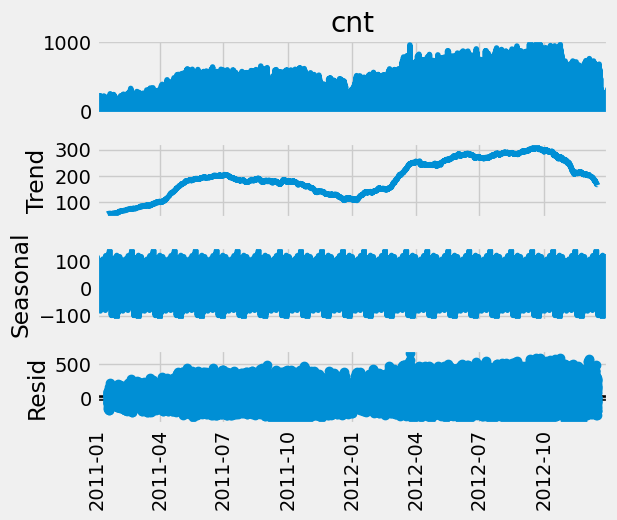

In [10]:
#Seasonal decomposition monthly
result = seasonal_decompose(bike_rentals["cnt"], model="additive", period=(24*30))

#Plot decomposition
result.plot()
plt.xticks(rotation=90)
plt.show()

Since we have quite a lot of data, it is difficult to understand any kind of pattern for seasonality of trend.

## Task 4
Create the lag and rolling windows features for the "cnt" column such 

Feature engineering involves transforming raw time serires data into a format that can be used for building machine learning models effectivley. The goal is to extract meaningful features that capture uderlying patterns, trends and dependencies in the data.

For this task we are going to create:
1. Lag features: which refer to past observateions in the time series, shifted by onr or more time steps. 
* They capture the the temporal dependencies that help predict futute values.
2. Rolling statistics: Used to smooth out short-terms fluctuations and highlight longer-term trends or cycles.
*  A rolling window of a sepcifc size is applied to calculate the statistics over time.

Also we have to take into account autocerrelation in order our model not to overestimate while predicting and miss dynamics, assuming independence in the data.
Creating the lag features we can correlate our time series and its lagged varsion over time, helping us predict future ones. 



For this task we will create:
1. Lag of 1 day identify daily patterns and potential peak days.
2. Lag of a quarter to detect seasonal variations.
3. Lag of 1 year to compare year-over-year changes.
4. Rolling mean for the same  week last month to indetify underlying trends for the same week last month and smooth noisy data for extrame fluctuations.
5. Rolling mean for the same quarter last year. 
 

In [11]:
#Function to Create Features
def create_features(df: pd.DataFrame):
    df = df.copy()

    #Lag Features
    df["lag_1d"] = df["cnt"].shift(24)
    df["lag_1q"] = df["cnt"].shift(120 * 24)
    df["lag_1y"] = df["cnt"].shift(365 * 24)

    #Rolling Statistics
    df["rolling_mean_same_week_last_year"] = df["cnt"].shift(365).rolling(window=(7*24)).mean()
    df["rolling_mean_same_quarter_last_year"] = df["cnt"].shift(365).rolling(window=(120*24)).mean()

    return df

In [12]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.9 MB


Even though from the summary of the dataset, it seems that there are not categorial features, with a deeper look we find out that season and weather situations are caregorical. In order to get better results from our model we are creating dummy variables from these features droping the first feature to avoid collinearity.

In [13]:
#Create Dummy variables
bike_rentals = pd.get_dummies(bike_rentals, columns=["season", "weathersit"], drop_first=True, dtype=int)

Clarification :
**season:** The season (1: Spring, 2: Summer, 3: Fall, 4: Winter).
**weathersit:** Weather condition (1: Clear, 2: Mist, 3: Light Rain, 4: Heavy Rain).

Now we can create the final dataset for the model.

In [14]:
df = create_features(bike_rentals)

## Task 6
Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

First we need to split the dataset into train-validation-test split.
We are going apply cross validation split using TimeSeriesSplit fucntion from sklearn libariary. First we devide the train-test and then we apply for train-test for the training data.



In [15]:
#Train-Tess split
from sklearn.model_selection import TimeSeriesSplit, train_test_split
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(df):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = df.iloc[train_index], df.iloc[test_index]

#Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


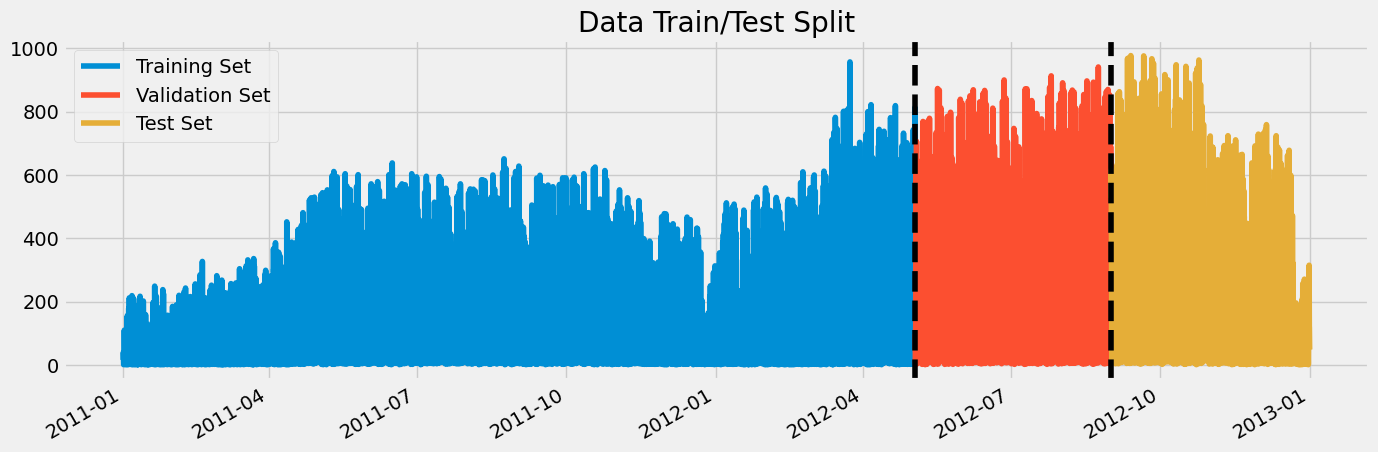

In [16]:
#Plot the dataset
fig, ax = plt.subplots(figsize=(15, 5))
X_train["cnt"].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
X_val["cnt"].plot(ax=ax, label='Validation Set')
X_test["cnt"].plot(ax =ax, label="Test Set")
ax.axvline(X_train.index.max(), color='black', ls='--')
ax.axvline(X_val.index.max(), color='black', ls='--')
ax.legend(['Training Set', 'Validation Set','Test Set' ])
plt.show()

In time series we have to preserve the ordr of the data, hence a classic train-test-split with the common ration 80-20 is not complety off, but using TimeSeriesSplit we also apply cross validation to the data getting a better result in the split. This waya we get more robust assesement of the model performance and help us to mitigate the impact of variance and ensures that our model generalzies well. 
Once we split the train-test data, then we can split the train-validation data more safely with the common ratio.

In [17]:
#Create the dependent and independent variables
X_train, X_val , X_test = X_train.drop(columns=["cnt"]),X_val.drop(columns=["cnt"]), X_test.drop(columns=["cnt"])
y_train, y_val, y_test = y_train["cnt"],y_val["cnt"], y_test["cnt"]

XGBoost Implementation

In [18]:
#Create DMAtrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

#Set Parameters
params = {
    'objective': 'reg:squarederror', #Objective funtcion for regression
    'eval_metric': 'rmse', #Evaluation metric
    'max_depth': 6, #Maximum depth of the tree
    'learning_rate':0.01,  #Learning rate
    'colsample_bytree':0.8, #Subsample ratio of columns(features) when constructing each tree
    'subsample':0.8, #Subsample ratio of the training instances
}

#watchlist for monitoring performance on train, validation and test set
wacthlist = [(dtrain, 'train'),((dval, 'validate')) ,(dtest, 'eval')]

#Number of boosting rounds and early stopping
num_round = 1000
early_stopping_rounds = 50

#Train the model
xgb_model = xgb.train(params, dtrain, num_round, evals=wacthlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=100)


#Predict for the val set
y_pred_val_xgb = xgb_model.predict(dval)
#Predict of the test set
y_pred_test_xgb = xgb_model.predict(dtest)

[0]	train-rmse:146.63086	validate-rmse:250.08057	eval-rmse:233.35351
[100]	train-rmse:82.49704	validate-rmse:148.11068	eval-rmse:149.41154
[200]	train-rmse:58.85247	validate-rmse:107.59641	eval-rmse:116.55152
[300]	train-rmse:47.37118	validate-rmse:91.11168	eval-rmse:102.34911
[400]	train-rmse:40.62863	validate-rmse:83.02891	eval-rmse:95.27600
[500]	train-rmse:36.58347	validate-rmse:79.04224	eval-rmse:91.79353
[600]	train-rmse:33.44241	validate-rmse:76.95653	eval-rmse:90.16699
[700]	train-rmse:31.32931	validate-rmse:75.91709	eval-rmse:89.56636
[787]	train-rmse:29.66671	validate-rmse:75.01551	eval-rmse:89.40563


In [19]:
from sklearn.metrics import mean_squared_error

#Evaluation metrics for the evaluation metrics
rmse_val_xgb = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
mae_val_xgb = mean_absolute_error(y_val, y_pred_val_xgb)

print(f"XGBoost val RMSE: {rmse_val_xgb:.3f}")
print(f"XGBoost val MAE: {mae_val_xgb:.3f}")

#Evaluation metrics for the test set
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)

print(f"XGBoost Test RMSE: {rmse_xgb:.3f}")
print(f"XGBoost Test MAE: {mae_xgb:.3f}")

XGBoost val RMSE: 74.985
XGBoost val MAE: 50.931
XGBoost Test RMSE: 89.379
XGBoost Test MAE: 58.760


The hugher values for the evaluation metrics of the test set are higher, indicating that our model potentially is overffiting on the evaluation set and does not generilze that well on unseed data.

Assuming that we are happy with our results, lets train the model without the validatoion split. And get the predictions for the last week.

In [20]:
#Merge the train and evaluation sets
X_train = pd.concat([X_train, X_val], axis=0)
y_train = pd.concat([y_train, y_val], axis=0)

In [21]:
#Create DMAtrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#Set Parameters
params = {
    'objective': 'reg:squarederror', #Objective funtcion for regression
    'eval_metric': 'rmse', #Evaluation metric
    'max_depth': 6, #Maximum depth of the tree
    'learning_rate':0.01,  #Learning rate
    'colsample_bytree':0.8, #Subsample ratio of columns(features) when constructing each tree
    'subsample':0.8, #Subsample ratio of the training instances
}

#watchlist for monitoring performance on train, validation and test set
wacthlist = [(dtrain, 'train'),(dtest, 'eval')]

#Number of boosting rounds and early stopping
num_round = 1000
early_stopping_rounds = 50

#Train the model
xgb_model = xgb.train(params, dtrain, num_round, evals=wacthlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=100)

#Predict of the test set
y_pred_test_xgb = xgb_model.predict(dtest)

[0]	train-rmse:170.67891	eval-rmse:225.59388
[100]	train-rmse:94.96640	eval-rmse:139.18277
[200]	train-rmse:66.79700	eval-rmse:108.41291
[300]	train-rmse:53.83651	eval-rmse:94.63289
[400]	train-rmse:46.23961	eval-rmse:87.32221
[500]	train-rmse:41.63578	eval-rmse:83.03474
[600]	train-rmse:38.48576	eval-rmse:80.62188
[700]	train-rmse:36.15235	eval-rmse:79.48929
[800]	train-rmse:34.08287	eval-rmse:78.44836
[900]	train-rmse:32.49474	eval-rmse:77.98096
[999]	train-rmse:31.14117	eval-rmse:77.71635


In [22]:
#Evaluation metrics for the test set
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)

print(f"XGBoost Test RMSE: {rmse_xgb:.3f}")
print(f"XGBoost Test MAE: {mae_xgb:.3f}")

XGBoost Test RMSE: 77.716
XGBoost Test MAE: 51.485


We can notice that when the model is trained on larger data it has better performance. If we followed more structured procedure and applied hyperparameters tuning we could potentially end up with even better model.

Lets visulaize though how our prediction correspond to the actual data, for the last week particularly.

In [23]:
if 'prediction' not in df.columns:
    X_test['prediction'] = xgb_model.predict(dtest)
    df = df.merge(X_test[['prediction']], how='left', left_index=True, right_index=True)

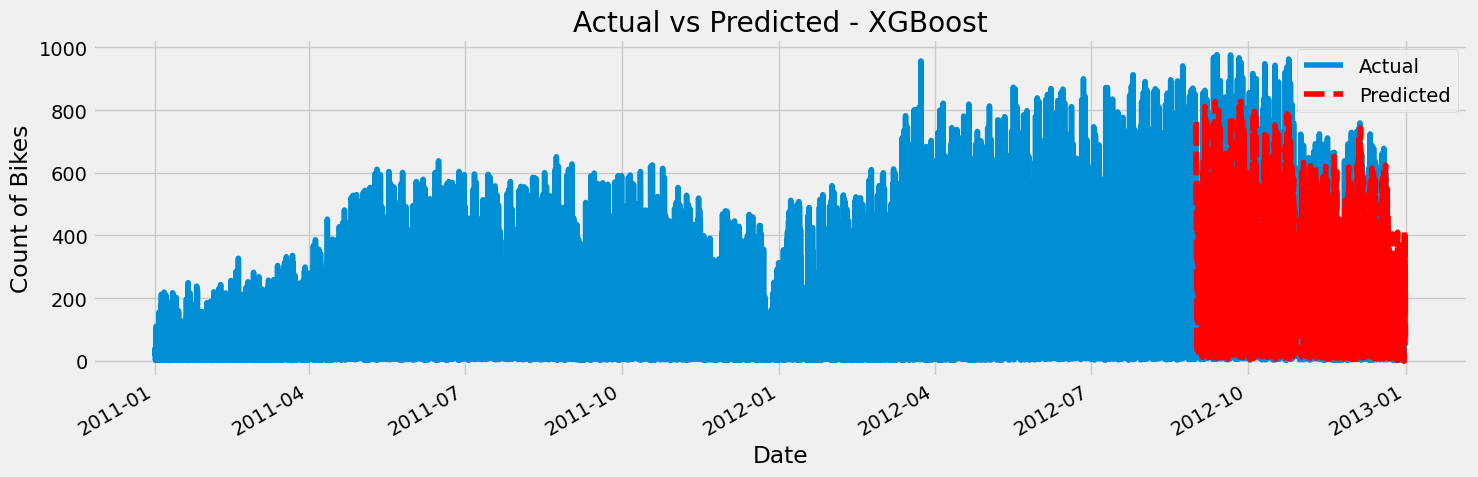

In [24]:
#Plot actual vs predicted
ax = df[["cnt"]].plot(figsize=(15, 5), title='Actual vs Predicted - XGBoost')
df["prediction"].plot(ax=ax, linestyle='--', color='red')

#Add labels and legend
plt.legend(['Actual', 'Predicted'])
ax.set_title("Actual vs Predicted - XGBoost")
plt.xlabel("Date")
plt.ylabel("Count of Bikes")
plt.tight_layout()
plt.show()

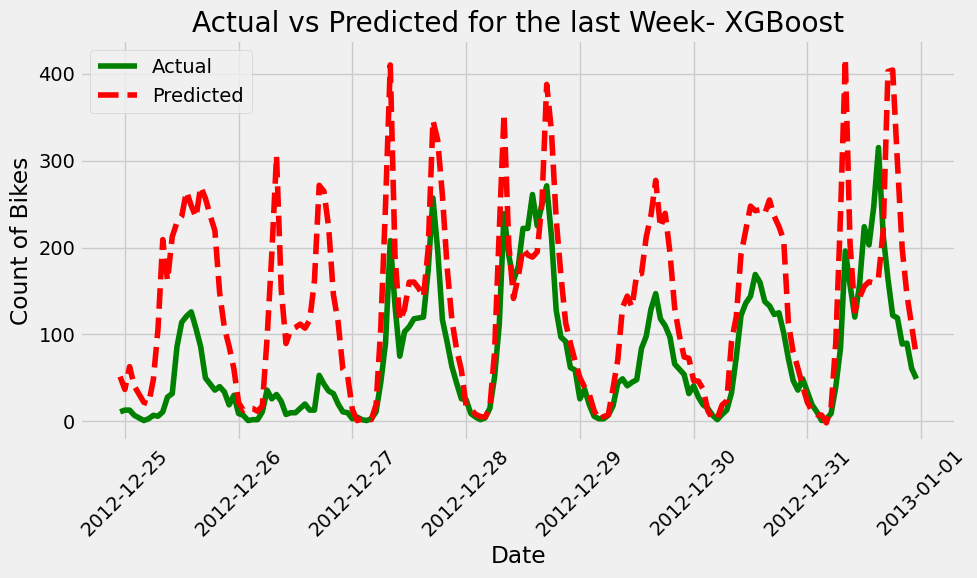

In [25]:
#Slice the last week of data
#Define the start and end date of the week intrested in
end_date = y_test.index.max()
start_date = end_date - pd.Timedelta(days=7)

#Filter for the week
y_test_week = y_test.loc[start_date:end_date]

#Ensure that predictions column is aligned with the same index as y_test_week
y_pred_xgb = df["prediction"].loc[start_date:end_date]

#Plot actual vs predicted for the week
plt.figure(figsize=(10,6))
plt.plot(y_test_week.index, y_test_week, label='Actual', color='green')
plt.plot(y_test_week.index, y_pred_xgb, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted for the last Week- XGBoost')
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Count of Bikes")
plt.legend()
plt.tight_layout()
plt.show()


We see that the predictions and the actuals values follow the same pattern somewhat.